### European wholesale electricity price data
https://ember-climate.org/data-catalogue/european-wholesale-electricity-price-data/

In [4]:
import warnings
warnings.filterwarnings('ignore')
import requests, io
import pandas as pd
url = 'https://ember-climate.org/app/uploads/2022/09/european_wholesale_electricity_price_data_monthly-5.csv'
df = pd.read_csv(io.StringIO(requests.get(url).text))
df = df[df.Country == 'France'].drop(columns=['Country','ISO3 Code']).rename(columns={'Price (EUR/MWhe)':'Price'}).set_index('Date')
df.index = pd.date_range(df.index.min(), periods=len(df), freq="M")
df.T

,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,...,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30
Price,41.95,50.14,43.79,39.52,26.46,32.16,37.91,32.19,37.45,44.96,...,400.95,492.99,393.55,178.89,192.16,270.49,132.28,148.78,111.81,106.45


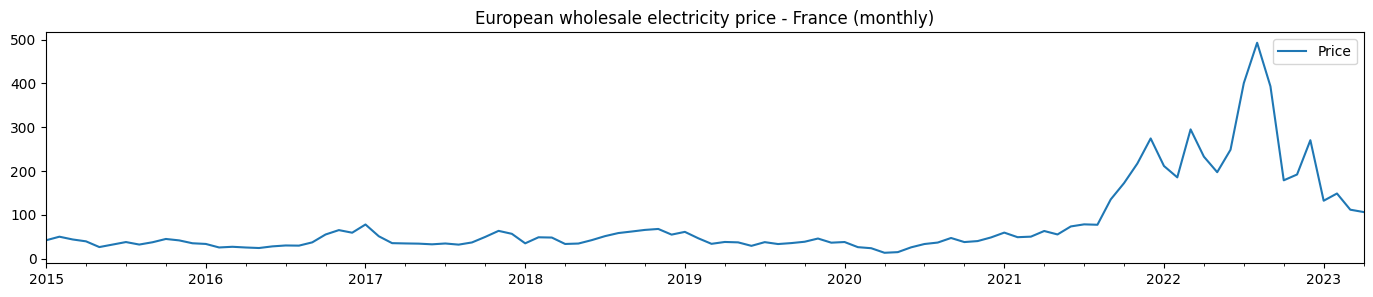

In [2]:
df.plot(figsize=(17,3), title='European wholesale electricity price - France (monthly)');

### Forecast from 2021-09-30

#### Train and Test split

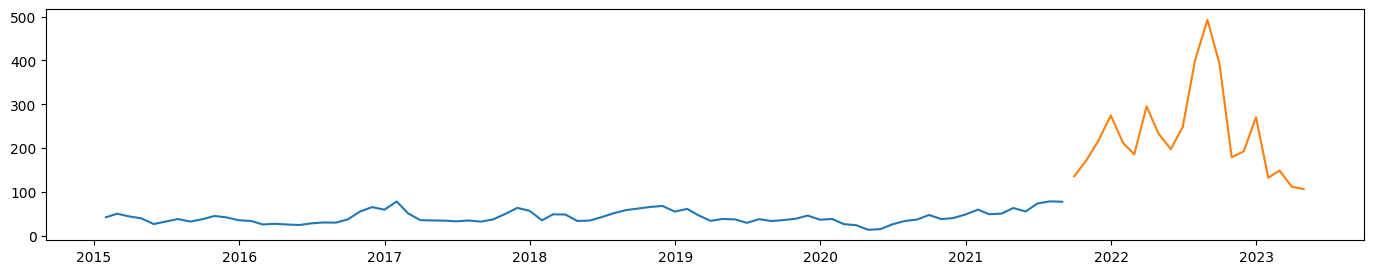

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(17,3))
train = df.loc[:'2021-08-31']
test = df.loc['2021-09-30':]
plt.plot(train)
plt.plot(test);

#### PACF

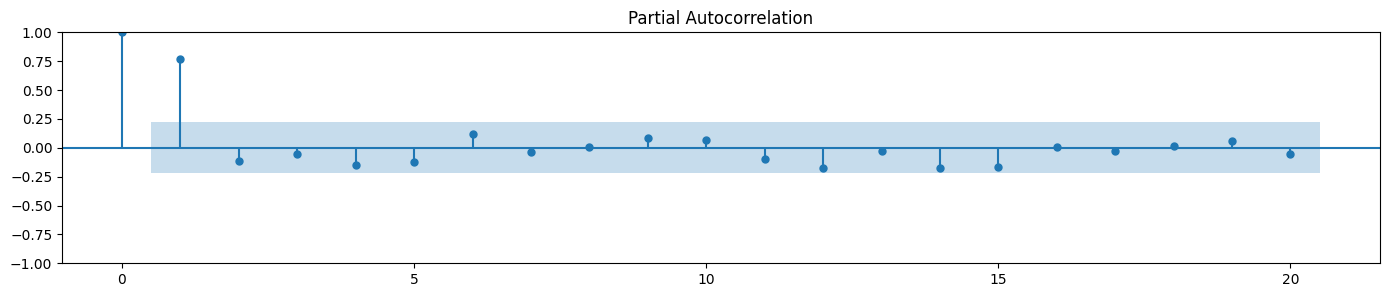

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17,3)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(train);

We see 1-2 AR lags

#### KPSS test

In [15]:
import warnings
warnings.filterwarnings('ignore')
%precision 6
from statsmodels.tsa.stattools import kpss
KPSS = kpss(train)
KPSS

(0.180899,
 0.100000,
 4,
 {'10%': 0.347000, '5%': 0.463000, '2.5%': 0.574000, '1%': 0.739000})

So we fail to reject the Null hypothesis of non-stationarity with alpha 0.1

#### SARIMA

In [17]:
import statsmodels.api as sm
fit = sm.tsa.statespace.SARIMAX(train, order=(1,0,0), seasonal_order=(2, 1, 0, 12)).fit(disp=0)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                   80
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -249.339
Date:                            Mon, 22 May 2023   AIC                            506.679
Time:                                    13:02:22   BIC                            515.557
Sample:                                01-31-2015   HQIC                           510.197
                                     - 08-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8474      0.063     13.446      0.000       0.724       0.971
ar.S.L12      -0.9003      0.115     -7.827      0.000      -1.126      -0.675
ar.S.L24      -0.4235      0.103     -4.126      0.000      -0.625      -0.222
sigma2        75.2501     12.628      5.959      0.000      50.501     100.000
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.71   Prob(JB):                         0.80
Heteroskedasticity (H):               1.39   Skew:                             0.01
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""